# Analysis of Utility of Synthetic South Korean COVID-19 patient data.

In [1]:
import itertools

import matplotlib.pyplot as plt

from scipy.spatial import KDTree

from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

from helper_functions import *

In [2]:
train_data = pd.read_csv("../Data/SK/cleaned_sk_data.csv")

In [3]:
sXs_mnl = [pd.read_csv("../Data/SK/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]
# ad_sXs_mnl = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

sXs_cart = [pd.read_csv("../Data/SK/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]
#A ad_sXs_cart = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

sXs_mostly = [pd.read_csv("../Data/SK/Synthetic Datasets/mostly_" + str(i) + ".csv") for i in range(20)]

***

## Utility Measure 1 - pMSE Ratios

In [4]:
ratios_mnl = [pmse_ratio(train_data, Y) for Y in sXs_mnl]
print(np.mean(ratios_mnl))

# ratios_ad_mnl = [pmse_ratio(train_data, Y) for Y in ad_sXs_mnl]
# print(np.mean(ratios_ad_mnl))

ratios_cart = [pmse_ratio(train_data, Y) for Y in sXs_cart]
print(np.mean(ratios_cart))

# ratios_ad_cart = [pmse_ratio(train_data, Y) for Y in ad_sXs_cart]
# print(np.mean(ratios_ad_cart))

ratios_mostly = [pmse_ratio(train_data, Y) for Y in sXs_mostly]
print(np.mean(ratios_mostly))

0.9832630986434936
1.0491764405084245
1.4300094825482423


***

Save data for plotting in R.

In [5]:
pmse_results = pd.DataFrame({'Dataset': np.arange(1, len(ratios_mnl)+1),
                             'MNL': ratios_mnl,
                             # 'AD-MNL': ratios_ad_mnl,
                             'CART': ratios_cart,
                             # 'AD-CART': ratios_ad_cart,
                             'MOSTLY.AI': ratios_mostly})

pmse_results = pmse_results.melt(id_vars=["Dataset"], value_vars=["MNL", "CART", "MOSTLY.AI"], var_name="Type")
pmse_results.to_csv('../Results/SK/pmse_metrics.csv', index=False)

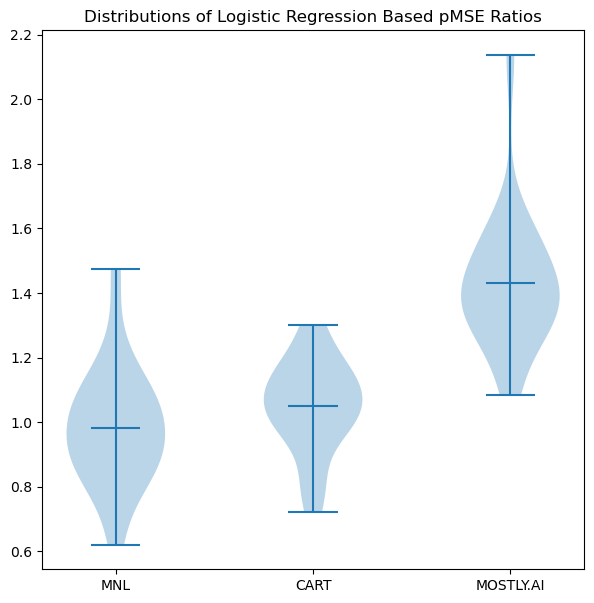

In [6]:
# Combine data
plot_data = list([ratios_mnl, ratios_cart, ratios_mostly])

fig, ax = plt.subplots(figsize=(7,7))

xticklabels = ["MNL", "CART", "MOSTLY.AI"]
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

***

# Utility Measure 2: Visual Comparison of Locations

Visual comparison of location distributions.

Save select data sets for plotting locations in R.

In [7]:
locations = pd.concat([pd.concat([pd.Series(np.repeat('Original', train_data.shape[0])), train_data.loc[:,['latitude', 'longitude', 'state']]], axis=1),
                       pd.concat([pd.Series(np.repeat('MNL', sXs_cart[0].shape[0])), sXs_cart[0].loc[:,['latitude', 'longitude', 'state']]], axis=1),
                       # pd.concat([pd.Series(np.repeat('AD - MNL', ad_sXs_cart[0].shape[0])), ad_sXs_cart[0].loc[:,['latitude', 'longitude', 'state']]], axis=1),
                       pd.concat([pd.Series(np.repeat('MOSTLY.AI', sXs_mostly[0].shape[0])), sXs_mostly[0].loc[:,['latitude', 'longitude', 'state']]], axis=1)]).reset_index(drop=True)

locations.to_csv('../Results/SK/locations.csv', index=False)

In [8]:
def scatter_plot(ax1, location_data, plot_title, xlab, ylab):
    
    ax1.scatter(location_data.longitude, location_data.latitude)
    
    ax1.set_title(plot_title)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab)
    ax1.set_ylim(-4, 2)
    ax1.set_xlim(-2, 2.5)

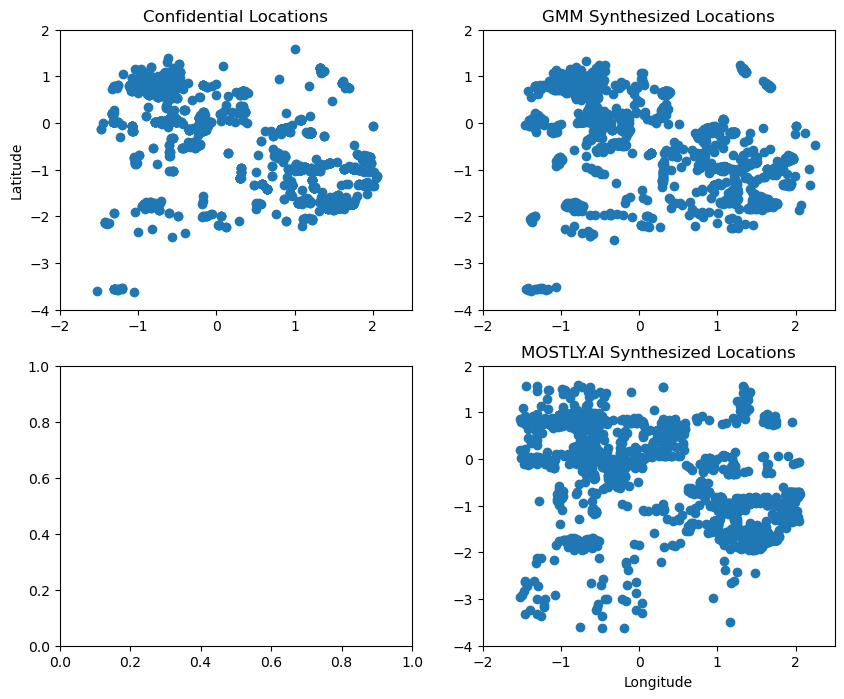

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
scatter_plot(ax[0,0], train_data, "Confidential Locations", "", "Latitude")
scatter_plot(ax[0,1], sXs_cart[0], "GMM Synthesized Locations", "", "")
# scatter_plot(ax[1,0], ad_sXs_cart[0], "AD - GMM Synthesized Locations", "Longitude", "Latitude")
scatter_plot(ax[1,1], sXs_mostly[0], "MOSTLY.AI Synthesized Locations", "Longitude", "")

***

# Utility Metric 3: Analysis Specific Utility

###  * L1 distance between confidential and synthetic coefficient estimates
###  * Confidence interval ratio
###  * Sign, Significance, and Overlap (SSO)

Analysis specific utility.

Use logistic regression to predict COVID-19 deaths based on latitude and longitude, age, and sex.

Compute the model for the original data.

***

In [10]:
def age_binary(data_set):
    new_age = pd.Series(np.repeat(0, data_set.shape[0]))
    new_age.loc[data_set.age==6] = 1
    new_age.loc[data_set.age==7] = 1
    new_age.loc[data_set.age==8] = 1
    new_age.loc[data_set.age==9] = 1

    data_set['age'] = new_age

    return data_set

In [11]:
age_binary(train_data)

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,1,0,0
1,0.889746,-0.694899,1,0,0
2,0.917482,-0.682299,1,0,0
3,0.916660,-0.682551,1,0,0
4,0.886074,-0.668883,1,0,0
...,...,...,...,...,...
6707,0.881500,-0.925307,1,0,0
6708,-1.728784,1.470871,1,0,0
6709,-1.548071,1.557316,1,0,0
6710,-1.549392,1.555785,1,0,0


***

In [12]:
def logit_param_fetcher(data, y, X):
    predictors = data.loc[:, X]
    predictors = add_constant(predictors)
    state_logit = Logit(endog=data.loc[:, y], exog=predictors)
    logit_results = state_logit.fit()
    return {"params": logit_results.params, 
            "l_var": np.diag(logit_results.cov_params()),
            "CI": logit_results.conf_int().reset_index(drop=True)}

Compute point estimate similarity (L1 distance between synthetic and original coefficients).

Do for one type of synthetic data sets for now.

In [13]:
logit_train = logit_param_fetcher(data=train_data, y='state', X=['latitude', 'longitude', 'sex', 'age'])

Optimization terminated successfully.
         Current function value: 0.034034
         Iterations 11


***

In [14]:
logit_train

{'params': const       -7.808408
 latitude     0.123915
 longitude    0.281379
 sex          1.443160
 age          3.978782
 dtype: float64,
 'l_var': array([0.23088949, 0.04874646, 0.05248047, 0.10150451, 0.19031739]),
 'CI':           0         1
 0 -8.750189 -6.866626
 1 -0.308818  0.556647
 2 -0.167622  0.730379
 3  0.818720  2.067600
 4  3.123740  4.833824}

Of the original estimates, the only statistically significant coefficient is for the effect of `age` on `state`: older individuals have a higher probability of passing away from COVID-19. We are interested in whether the synthetic data estimates preserve this inference, while also preserving the conclusions that none of the other variables have a statistically significant effect.

We'll start with the L1 distances of the coefficients across the individual synthetic data sets.

Now, write a function that performs all previous steps given a synthetic data set and the train data set, returning a dataframe with the L1 differences in coefficients and a column that identifies the data type.

In [15]:
all_synthetic_data = [sXs_mnl, sXs_cart, sXs_mostly]

In [16]:
for i in all_synthetic_data:
    for j in i:
        age_binary(j)

Combine the above into the L1 function, make it so one variable could be used to do a join at the end.

In [17]:
def coef_L1_calc(original_data, synthetic_datasets, synthetic_data_type, target_variable, exog_variables, param_names):

    # copy synthetic datasets so they don't get edited on a global scope
    all_synth = synthetic_datasets.copy()

    # train a logistic regression model with state as the target and lat, long, sex, age, and sex*age as predictors
    # function returns all parameter estimates, standard errors, and confidence intervals for the training data
    logit_train = logit_param_fetcher(data=original_data, y=target_variable, X=exog_variables)

    # estimate the same logistic regression model for all synthetic data sets and save params, standard errors, and CIs
    logit_synth = [logit_param_fetcher(data=Y, y=target_variable, X=exog_variables) for Y in synthetic_datasets]

    # create a dataframe with the L1 distances for each coefficient in the columns, (rows are for each synthetic data set)
    # and a column identifying the data type
    l1_frame = pd.DataFrame()

    # calculate L1 distance
    for i in logit_synth:
        l1_frame = pd.concat([l1_frame, np.abs(i['params'] - logit_train['params'])], axis=1)

    l1_frame = l1_frame.T.reset_index(drop=True)
    l1_frame.columns = param_names
    l1_frame['Data Type'] = synthetic_data_type
    l1_frame['Measure'] = 'L1 Distance'

    # calculate CI ratio (width of synthetic / width of original)
    # calculate confidence interval ratios
    CI_ratio_frame = pd.DataFrame()
    for i in logit_synth:
        CI_ratio_frame = pd.concat([CI_ratio_frame, (i['CI'].iloc[:,1]-i['CI'].iloc[:,0]) / (logit_train['CI'].iloc[:,1]-logit_train['CI'].iloc[:,0])], axis=1)

    CI_ratio_frame = CI_ratio_frame.T.reset_index(drop=True)
    CI_ratio_frame.columns = param_names
    CI_ratio_frame['Data Type'] = synthetic_data_type
    CI_ratio_frame['Measure'] = 'CI Ratio'
    
    # calculate whether the signs of coefficients match
    sign_frame = pd.DataFrame()
    for i in logit_synth:
        sign_frame = pd.concat([sign_frame, abs(logit_train['params']) + abs(i['params']) == abs(logit_train['params'] + i['params'])], axis=1)

    sign_frame = sign_frame.T.reset_index(drop=True)
    sign_frame.columns = param_names
    sign_frame['Data Type'] = synthetic_data_type
    sign_frame['Measure'] = 'Sign Match'
    
    # check whether the statistical significance of the coefficients matches
    sig_frame = pd.DataFrame()
    orig_sig = pd.concat([logit_train['CI'].iloc[:,0] <= 0, 0 <= logit_train['CI'].iloc[:,1]], axis=1).all(axis=1)
    for i in logit_synth:
        sig_frame = pd.concat([sig_frame, pd.concat([i['CI'].iloc[:,0] <= 0, 0 <= i['CI'].iloc[:,1]], axis=1).all(axis=1).eq(orig_sig, axis=0)], axis=1)

    sig_frame = sig_frame.T.reset_index(drop=True)
    sig_frame.columns = param_names
    sig_frame['Data Type'] = synthetic_data_type
    sig_frame['Measure'] = 'Significance Match'
    
    # check whether confidence intervals overlap
    overlap_frame = pd.DataFrame()
    for synth in logit_synth:
        overlaps = []
        for i,j in synth['CI'].iterrows():
            i1 = pd.Interval(logit_train['CI'].iloc[i,0], logit_train['CI'].iloc[i,1], closed='both')
            i2 = pd.Interval(j[0], j[1], closed='both')
            overlaps.append(i1.overlaps(i2))
        overlap_frame = pd.concat([overlap_frame, pd.Series(overlaps)], axis=1)

    overlap_frame = overlap_frame.T.reset_index(drop=True)
    overlap_frame.columns = param_names
    overlap_frame['Data Type'] = synthetic_data_type
    overlap_frame['Measure'] = 'CI Overlap'

    # create dataframe with the actual point estimates and confidence intervals
    p_and_i_full = pd.DataFrame()
    
    for i, Z in enumerate(logit_synth):
        p_and_i = pd.concat([Z['params'].reset_index(), Z['CI']], axis=1)
        p_and_i.columns = ['Parameter', 'Point Estimate', 'Lower Bound', 'Upper Bound']
        p_and_i.loc[:,'Type'] = synthetic_data_type
        p_and_i.loc[:,'index'] = i
        p_and_i_full = pd.concat([p_and_i_full, p_and_i], axis=0)

    p_and_i_full = p_and_i_full.reset_index(drop=True)

    return pd.concat([l1_frame, CI_ratio_frame, sign_frame, sig_frame, overlap_frame], axis=0), p_and_i_full

In [18]:
all_data = [[train_data], sXs_mnl, sXs_cart, sXs_mostly]

In [19]:
all_data_types = ['Original', 'MNL', 'CART', 'MOSTLY.AI']

In [20]:
all_l1_results = pd.DataFrame()
all_p_and_i_results = pd.DataFrame()

for i, j in enumerate(all_data):
    current_l1_results, current_p_and_i_results = coef_L1_calc(original_data=train_data, synthetic_datasets=j, synthetic_data_type=all_data_types[i],
                                                               target_variable='state', exog_variables=['latitude', 'longitude', 'sex', 'age'],
                                                               param_names=['Intercept', 'Latitude', 'Longitude', 'Sex', 'Age'])

    all_l1_results = pd.concat([all_l1_results, current_l1_results.reset_index()], axis=0)
    all_p_and_i_results = pd.concat([all_p_and_i_results, current_p_and_i_results])

Optimization terminated successfully.
         Current function value: 0.034034
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.034034
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.034034
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.039519
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.035427
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.040962
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030374
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.035875
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.028315
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

In [21]:
all_l1_results

,index,Intercept,Latitude,Longitude,Sex,Age,Data Type,Measure
0,0,0.0,0.0,0.0,0.0,0.0,Original,L1 Distance
1,0,1.0,1.0,1.0,1.0,1.0,Original,CI Ratio
2,0,1.0,1.0,1.0,1.0,1.0,Original,Sign Match
3,0,1.0,1.0,1.0,1.0,1.0,Original,Significance Match
4,0,1.0,1.0,1.0,1.0,1.0,Original,CI Overlap
...,...,...,...,...,...,...,...,...
95,15,1.0,1.0,1.0,1.0,1.0,MOSTLY.AI,CI Overlap
96,16,1.0,1.0,1.0,1.0,1.0,MOSTLY.AI,CI Overlap
97,17,1.0,1.0,1.0,1.0,1.0,MOSTLY.AI,CI Overlap
98,18,1.0,1.0,1.0,1.0,1.0,MOSTLY.AI,CI Overlap


In [22]:
all_p_and_i_results

,Parameter,Point Estimate,Lower Bound,Upper Bound,Type,index
0,const,-7.808408,-8.750189,-6.866626,Original,0
1,latitude,0.123915,-0.308818,0.556647,Original,0
2,longitude,0.281379,-0.167622,0.730379,Original,0
3,sex,1.443160,0.818720,2.067600,Original,0
4,age,3.978782,3.123740,4.833824,Original,0
...,...,...,...,...,...,...
95,const,-7.499438,-8.356625,-6.642251,MOSTLY.AI,19
96,latitude,-0.055623,-0.403241,0.291996,MOSTLY.AI,19
97,longitude,-0.167428,-0.546224,0.211368,MOSTLY.AI,19
98,sex,1.297217,0.725799,1.868634,MOSTLY.AI,19


In [23]:
all_l1_results = all_l1_results.melt(id_vars=["Data Type", "Measure", "index"], value_vars=['Intercept', 'Latitude', 'Longitude', 'Sex', 'Age'], var_name="Variable")

In [24]:
all_l1_results

,Data Type,Measure,index,Variable,value
0,Original,L1 Distance,0,Intercept,0.0
1,Original,CI Ratio,0,Intercept,1.0
2,Original,Sign Match,0,Intercept,1.0
3,Original,Significance Match,0,Intercept,1.0
4,Original,CI Overlap,0,Intercept,1.0
...,...,...,...,...,...
1520,MOSTLY.AI,CI Overlap,15,Age,1.0
1521,MOSTLY.AI,CI Overlap,16,Age,1.0
1522,MOSTLY.AI,CI Overlap,17,Age,1.0
1523,MOSTLY.AI,CI Overlap,18,Age,1.0


Save data for analysis and plotting in R.

In [25]:
all_p_and_i_results.to_csv('../Results/SK/point_estimates_and_intervals.csv', index=False)

In [26]:
all_l1_results.to_csv('../Results/SK/analysis_specific.csv', index=False)

***